# <p style="text-align: center;">Estimating Parameters from Gravitational Wave Signals</p>

##  <p style="text-align: center;"> Ashley Chraya</p>
### <p style="text-align: center;"> EMIT Summer School</p>

<p style="text-align: center;"><img src="VUlogo.jpg" alt="drawing" width="200"/></p>

### Make sure the software is set up ###


In [58]:
# 1. Create a new conda environment. Please follow the steps discussed here: https://code.visualstudio.com/docs/python/environments . I am using Python 3.9.16 Interpreter.

# 2. Install pycbc and its dependencies using pip: pip install pycbc

# 3. I just noticed that there is an error while initializing the EmceePT sampler in cell 14. The error is as follows:

#"AttributeError: module 'numpy' has no attribute 'float'.`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here."

# I was using the latest version of numpy 1.25.1 in my conda environment. By downgrading its version to 1.23.0, the error vanished so if anyone is facing similar error please downgrade numpy version. To downgrade, use the following command: pip install numpy==1.23.0 


In [ ]:
import sys
!{sys.executable} -m pip install pycbc ligo-common emcee==2.2.1 --no-cache-dir

# Introduction to inference

## An aside on conditional probability and Bayes' theorem/one-liner

- Throughout this tutorial, we'll be using the oft-talked about [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem):

$$ P(A|B) = \frac{P(B|A)P(A)}{P(B)} $$

- Before we begin, let's make sure we understand it

**Question:** What is the probability of drawing a red-suit card from a pack of 52 cards?

**Answer:** It is 1/2 *if* the 52-card deck of cards is regular

**Question:** How do you express that mathematically?

**Answer:**

$$ P(\textrm{red-card} | I) = \frac{1}{2} $$

where

$$ I \equiv \textrm{"normal 52-card deck"} $$

is our *background* information.

*The vertical line above can be read as "given"*

**Question:** What is the probability of drawing <span style="color:red"> 2 red-suit card from a pack of 52 cards</span>?

**Answer:** Uhh.. hang on let me draw a diagram
```
           O      
        /     \
       /       \
      R0       B0
      / \      /\
     /   \    /  \
    R1   B1  R1  B1
```

So...
$$R_0 = \frac{26}{52}=\frac{1}{2} \;\; \textrm{ and }\;\; R_1=\frac{26-1}{52-1}=\frac{25}{51}$$
so the probability of both occuring is 
$$ R_1 \times R_0 = \frac{25}{102} $$

**Question:** How do you express that mathematically?

**Answer:** We want $P(R_0, R_1| I)$, so we need to use *conditional probability*

$$ P(R_0, R_1| I) = P(R_1 | R_0, I) P(R_0| I) $$

with
$$ P(R_0 | I) = \frac{1}{2} $$
and
$$ P(R_1 | R_0, I) = \frac{\textrm{Number of red cards}}{\textrm{Number of cards}} = \frac{26-1}{52-1} = \frac{25}{51} $$

And so finally
$$ P(R_0, R_1| I) = \frac{1}{2} \times \frac{25}{51} = \frac{25}{102}$$

### Okay sorry, where were we?

You all understand conditional probability 
$$P(A, B| I ) = P(A| B, I)P(B| I)$$

But we can write that the other way around
$$P(A, B| I ) = P(B| A, I)P(A|I)$$

Then with a little algebra

$$ P(A| B, I) = \frac{P(B| A, I) P(A| I)}{P(B| I)} $$

- Which is just... Bayes' theorem.

- Maybe we should just call it Bayes' one-liner?

## Introduction to Inference

- **Inference is about figuring something out from the data**

- We will label, for now, our data as $\textbf{data}$

- Once you have some data it is time to decide what you want to figure out.

- Inference can be thought of in two ways:
  1. **Parameter estimation**: "*I want to figure our what model parameters $\theta$ best-fit my data, given some model $M_A$*"
  2. **Model selection**: "*I want to figure our which model, $M_A$ or $M_B$ best fits my data*"

## Parameter Estimation

Parameter estimation is about figuring out the model parameters $\theta$ given some model $M_A$

$$ P(\theta| M_A, \mathbf{data}) = \frac{P(\mathbf{data}| M_A, \theta) P(\theta | M_A)}{P(\mathbf{data} | M_A)}$$

The denomoninator here only normalises the distribution, so often people will simplify

$$ P(\theta| M_A, \mathbf{data}) \propto P(\mathbf{data}| M_A, \theta) P(\theta | M_A)$$

For consistency with notation elsewhere, this is often written

$$ \underbrace{P(\theta| M_A, \mathbf{data})}_{\textrm{posterior}} \propto \underbrace{\mathcal{L}(\mathbf{data}| M_A, \theta)}_{\textrm{likelihood}} \underbrace{\pi(\theta | M_A)}_{\textrm{prior}}$$

### Example 1: one-dimensional posterior distribution

Let's talk about some specific data $\mathbf{y} = [y_0, y_1, \ldots, y_N]$ observed at times $\mathbf{t} = [t_0, t_1, \ldots, t_N]$.

To be concrete: we will say

- Our model is
$$ M_A: y_A(t; \omega) = \sin(\omega t) $$
- We have one model parameter, i.e. $\mathbf{\theta}=[\omega]$

In [1]:
# Setup for the notebook: imports and set log levels to not produce too much output
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# This is just to make things "pretty" for presentation
import seaborn
np.random.seed(123)
seaborn.set_context("talk")
seaborn.set_style("whitegrid")

In [2]:
def modelA(time, omega):
    return np.sin(omega * time)

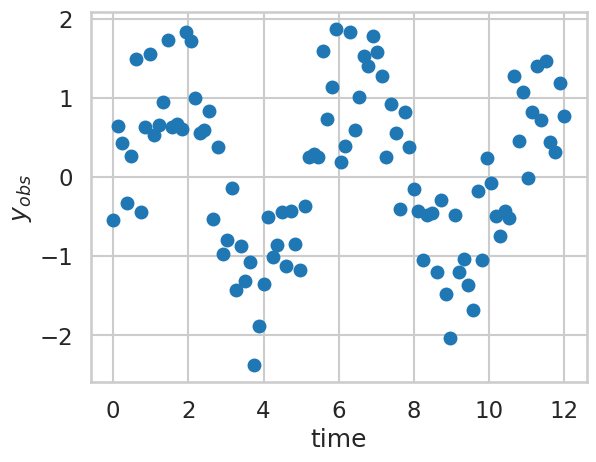

In [3]:
sigma = 0.5
omega_true = 1.2
time = np.linspace(0, 12, 100)
ydet = modelA(time, omega=omega_true)
yobs = ydet + np.random.normal(0, sigma, len(time)) 
# Observed data = SIGNAL + GAUSSIAN NOISE
plt.plot(time, yobs, "o")
plt.ylabel("$y_{obs}$"); plt.xlabel("time")
plt.show()

We want to *figure something out from the data*. Let's figure out the frequency

The *noise* is Gaussian, i.e. we have

$$ y_\textrm{obs} = y_\textrm{det} + \textrm{noise} => \textrm{noise} = y_\textrm{obs} - y_\textrm{det}$$

So, if we have a single data point $y_i, t_i$, then given a particular $\omega$

$$\mathcal{L}(y_i, t_i | \omega, M_A, \sigma=0.5) = \textrm{Normal}(y - y_A(t; \omega); \sigma=0.5) 
= \frac{1}{\sqrt{2\pi\sigma^2}} \mathrm{exp}\left(-\frac{(y_i-y(t_i)^2)}{2\sigma^2}\right)$$

It is a good idea to work with the log-likelihood
$$ \ln\mathcal{L}(y_i, t_i | \omega, M_A, \sigma=0.5) = -\frac{1}{2}\left(
\frac{(y_i-y_A(t_i))^2}{\sigma^2} + \ln({2\pi\sigma^2})
\right)$$

Last, we want the likelihood from **all** the data:
$$\mathcal{L}(\mathbf{y}, \mathbf{t} | \omega, M_A, \sigma=0.5) = \prod_{i}\mathcal{L}(y_i, t_i | \omega, M_A, \sigma=0.5)$$
or
$$\ln\mathcal{L}(\mathbf{y}, \mathbf{t} | \omega, M_A, \sigma=0.5) = \sum_{i}\ln\mathcal{L}(y_i, t_i | \omega, M_A, \sigma=0.5)$$

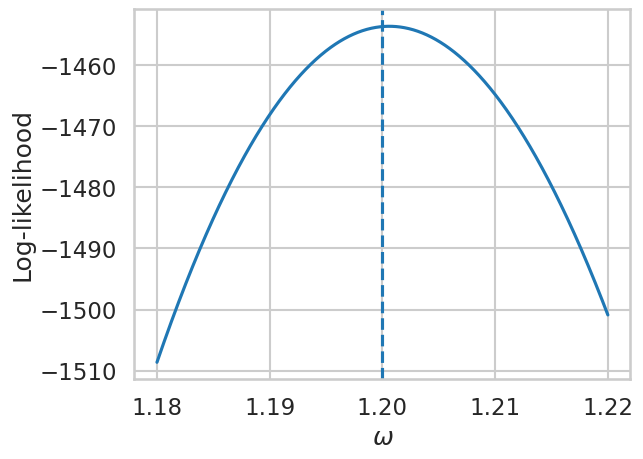

In [4]:
def ln_likelihood(yobs, time, omega, sigma=0.1):
    yA = modelA(time, omega)
    ln_likes = -0.5 * ((yobs - yA)**2 / sigma**2 
                       + np.log(2*np.pi*sigma**2))
    return np.sum(ln_likes)

omega_grid = np.linspace(omega_true-2e-2, omega_true+2e-2, 1000)
ln_likelihood_grid = []
for omega in omega_grid:
    ln_likelihood_grid.append(ln_likelihood(yobs, time, omega))
    
plt.plot(omega_grid, ln_likelihood_grid)
plt.axvline(omega_true, ls='--')
plt.xlabel("$\omega$")
plt.ylabel("Log-likelihood")
plt.show()

### Max likelihood

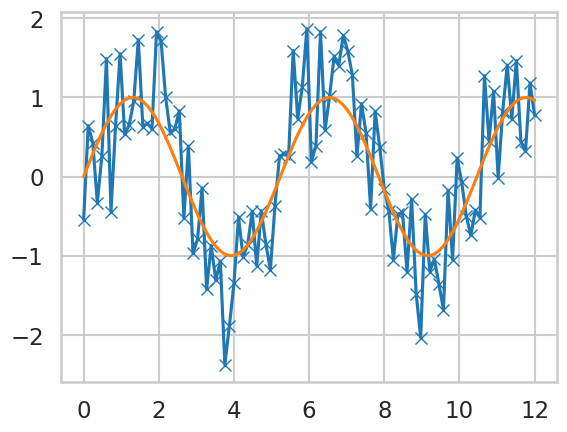

In [5]:
max_likelihood_omega = omega_grid[np.argmax(ln_likelihood_grid)]
plt.plot(time, yobs, '-x')
plt.plot(time, modelA(time, max_likelihood_omega))
plt.show()

## Posteriors

$$ P(\omega | \mathrm{data}) \propto \mathcal{L}(\mathrm{data}| \omega) \times \pi(\omega) $$

- If $\pi(\omega) \propto \textrm{const.}$, then $P(\omega | \mathrm{data}) \propto \mathcal{L}(\mathrm{data}| \omega)$
- If not, then one needs to do multiply by the prior.
- For the time being let's take the easier case

### Normalised posterior density function (pdf)

Let's plot the posterior (equal to the likelihood in this case) taking an exponent

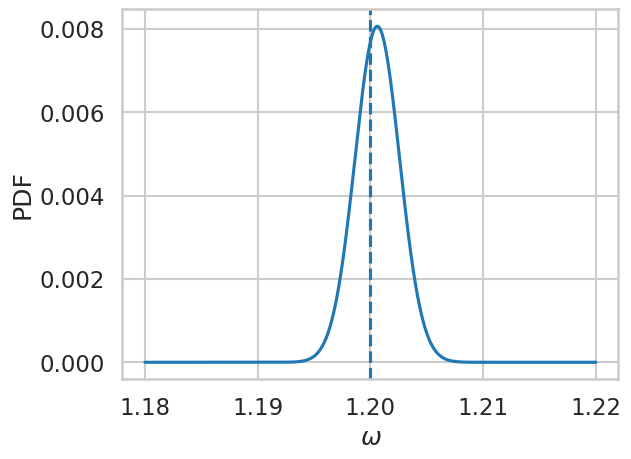

In [6]:
pdf_unnormalized = np.exp(ln_likelihood_grid 
                          - np.mean(ln_likelihood_grid))
pdf_normalized = pdf_unnormalized / np.sum(pdf_unnormalized)
plt.plot(omega_grid, pdf_normalized)
plt.axvline(omega_true, ls='--')
plt.xlabel("$\omega$")
plt.ylabel("PDF")
plt.show()

### Why is the peak not consistent with the true value?

- Cleary the median of this distribution does **not** agree with the true value
- The *noise* in the observed data means that we have uncertainty!
- How can be quantify this?
- Bayesian answer is the [credible interval](https://en.wikipedia.org/wiki/Credible_interval) 
- We should always report inferences as $\omega$ has a median of XX and lies between YY and ZZ with 90\% probability
- How do we figure out these numbers?

## Cumulative distribution

$$ \mathrm{CDF}(\omega) = \int_{-\infty}^{\omega} P(\omega'| \mathrm{data})\, d\omega' $$

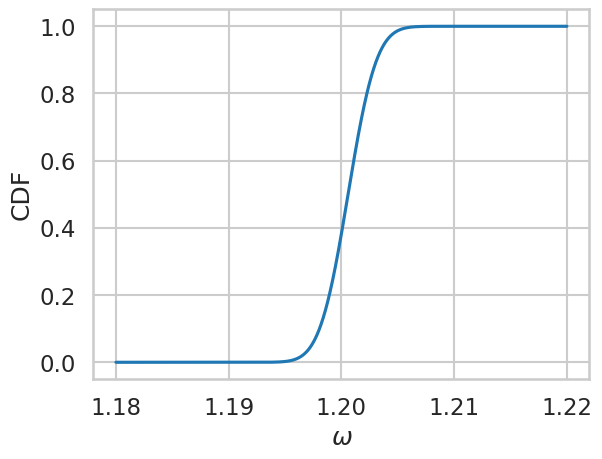

In [7]:
cdf = np.cumsum(pdf_normalized)
plt.plot(omega_grid, cdf)
plt.xlabel("$\omega$")
plt.ylabel("CDF")
plt.show()

- The median is the point where the CDF passes through 0.5
- We can find the 90% confidence interval by finding the 0.05 and 0.95 numbers

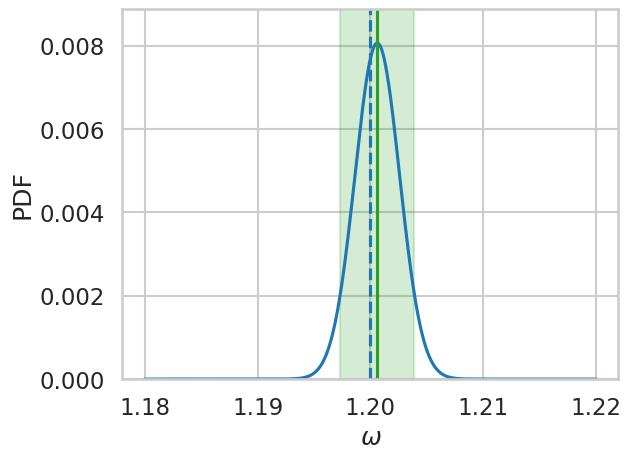

In [8]:
median = omega_grid[np.argmin(np.abs(cdf - 0.5))]
low_bound = omega_grid[np.argmin(np.abs(cdf - 0.05))]
upper_bound = omega_grid[np.argmin(np.abs(cdf - 0.95))]

plt.plot(omega_grid, pdf_normalized)
plt.axvline(omega_true, ls='--')
plt.fill_between([low_bound, upper_bound], 
                 0, 2 * np.max(pdf_normalized), color='C2', alpha=0.2)
plt.axvline(median, color='C2')
plt.ylim(0, 1.1 * np.max(pdf_normalized))
plt.xlabel("$\omega$")
plt.ylabel("PDF")
plt.show()

# Signal

Has two polarizations. Described by 15 parameters + 1 parameter per NS.
1. Intrinsic Parameters: Masses, spins etc.
2. Extrinsic Parameters: distance, sky location (RA, Dec) etc.

<p style="text-align: center;"><img src="mass1.png" alt="drawing" width="800"/></p>

Aligned Spins = Longer duration

<iframe width="1000" height="315" src="https://vijayvarma392.github.io/binaryBHexp/movies/hangup.mp4" title="YouTube video" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>


Misaligned Spin = Amplitude Variation

<iframe width="1000" height="315" src="https://vijayvarma392.github.io/binaryBHexp/movies/precessing.mp4" title="YouTube video" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

# Perform parameter estimation of GW170817 in a notebook #



## Estimating the distance of GW170817 ##

A `model` in pycbc inference represents the problem you are trying to solve. It contains the definition of the likelihood function you want to explore and details the parameters you are using. Let's take a look at some of the existing models that pycbc inference provides targeted at gravitational-wave data analysis. We'll start with the `SingleTemplate` model. This model is useful when we know the intrinsic parameters of a source (i.e. component masses, spins), but we don't know the extrinsic parameters (i.e. sky location, distance, binary orientation). This will allow us to estimate the distance to GW170817 and the inclination of the orbital plan from our viewing angle. 

This model requires a specifc set of data products.
  * Dictionary of frequency-domain data (keyed by observatory short name such as 'H1', 'L1', 'V1').
  * Dictionary of power spectral density estimates
  * Low frequency cutoff to use for internal filtering in the model
  
We will make use of PyCBC gw signal processing tools to prepare this data.

In [10]:
from pycbc.inference import models

for model_name in models.models:
    print(model_name)

test_eggbox
test_normal
test_rosenbrock
test_volcano
test_posterior
test_prior
gaussian_noise
marginalized_phase
marginalized_polarization
marginalized_hmpolphase
marginalized_time
brute_parallel_gaussian_marginalize
brute_lisa_sky_modes_marginalize
gated_gaussian_noise
gated_gaussian_margpol
single_template
relative
hierarchical
multi_signal


The models starting with `test_` are analytic models. These have predefined likelihood functions that are given by some standard distributions used in testing samplers. The other models are for gravitational-wave astronomy: they take in data and calculate a likelihood using an inner product between the data and a signal model. Currently, all of the gravitational-wave models in PyCBC assume that the data is stationary Gaussian noise in the absence of a signal. The difference between the models is they make varying simplfying assumptions, in order to speed up likelihood evaluation. marginalized_phase, marginalized_polarization, brute_parallel_gaussian_marginalize, single_template, relative assumes simplying assumptions.

In [11]:
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.frame import read_frame
from pycbc.filter import highpass, resample_to_delta_t
from astropy.utils.data import download_file

m = Merger("GW170817")

# List of observatories we'll analyze
ifos = ['H1', 
        'V1', 
        'L1',
       ]

In [12]:
# we'll keep track of the filename locations as we'll need them later
data_filenames = {}

# The single template waveform model needs these data products
psds = {}
data = {}

for ifo in ifos:
    print("Processing {} data".format(ifo))
    
    # Download the gravitational wave data for GW170817
    url = "https://dcc.ligo.org/public/0146/P1700349/001/{}-{}1_LOSC_CLN_4_V1-1187007040-2048.gwf"
    fname = download_file(url.format(ifo[0], ifo[0]), cache=True) 
    # Load into the memory
    data_filenames[ifo] = fname
    
    # Read the gravitational wave data and do some minimal
    # conditioning of the data.
    ts = read_frame(fname, "{}:LOSC-STRAIN".format(ifo),
                    start_time=int(m.time - 260),
                    end_time=int(m.time + 40)) 
    ts = highpass(ts, 15.0)                     
    # Remove low frequency content
    ts = resample_to_delta_t(ts, 1.0/2048)      
    # Resample data to 2048 Hz # Downsample to lower sampling rate
    ts = ts.time_slice(m.time-112, m.time + 16) 
    # Limit to times around the signal
    data[ifo] = ts.to_frequencyseries()         
    # Convert to a frequency series by taking the data's FFT

    # Estimate the power spectral density of the data
    psd = interpolate(ts.psd(4), ts.delta_f)
    psd = inverse_spectrum_truncation(psd, int(4 * psd.sample_rate), 
                                      trunc_method='hann',
                                      low_frequency_cutoff=20.0)
    psds[ifo] = psd



Processing H1 data
Processing V1 data
Processing L1 data


A number of parameters must also be provided as 'static' parameters. These include 
   * mass1 (Units in solar masses)
   * mass2 (Units in solar masses)
   * f_lower (used for where to start our gravitational waveform model generation from)
   * approximant (This sets which waveform model we are using)

If a model supports other intrinsic parameters (such as components spins), they may 
also optionally be provided.

There are also a fixed set of 'variable' parameters. These are the only ones which we
can obtain estimates of with this model. These are
   * ra        (Units in radians)
   * dec       (Units in radians)
   * distance  (Units in Megaparsecs)
   * inclination (Units in radians)
   * polarization (Units in radians)
   * tc           (Units in seconds): This parameter is roughly the time of merger.
   
It's important to note that anything which could be a variable paramater, can be transformed
into a static parameter by supplying a specific value for it. We take advantage of this below
to limit our analyis to only sample over 'distance', 'inclination', and 'tc'. We set the sky location
to the location of NGC 4993, the galaxy where an electromagnetic counterpart to GW170817 was observed.

In [13]:
from pycbc.inference import models, sampler
from pycbc.distributions import Uniform, JointDistribution, SinAngle
import numpy

static = {'mass1':1.3757,
          'mass2':1.3757,
          'f_lower':25.0,
          'approximant':"TaylorF2",
          'polarization':0,
          'ra': 3.44615914,
          'dec': -0.40808407
         }

variable = ('distance',
            'inclination',
            'tc')

prior = JointDistribution(variable,
                SinAngle(inclination=None), 
                Uniform(
                    distance=(10, 100),
                    tc=(m.time-.2, m.time+0.2),
                )
        )

We are not ready to create our SingleTemplate model instance. Note how the variable and static parameters
are passed to the model. This is a common way this information can be passed for built-in pycbc inference models.

While Emcee is sufficient for many problems, EmceePT, a parallel tempered version of Emcee is more effective at most gravitational-wave data analysis problems. There is one additional parameter we need to give to EmcceePT which is the number of temperatures. The output of this sampler will thus be 3-dimensional (temps x walkers x iterations). The 'coldest' temperature (0) will contain our actual results. 

In [14]:
import copy
model = models.SingleTemplate(variable, copy.deepcopy(data),
                              low_frequency_cutoff={'H1':25, 'L1':25, 'V1':25},
                              psds = psds,
                              static_params = static,
                              prior = prior,
                              sample_rate = 8192,
                              )
smpl = sampler.EmceePTSampler(model, 3,200, nprocesses=8)
_ = smpl.set_p0() # If we don't set p0, it will use the models prior to draw initial points!

In [15]:
# Note it may take ~1-3 minutes for this to run
smpl.run_mcmc(200)

In addition to the sampled parameters, we can also get the likelihood values our model produces. 

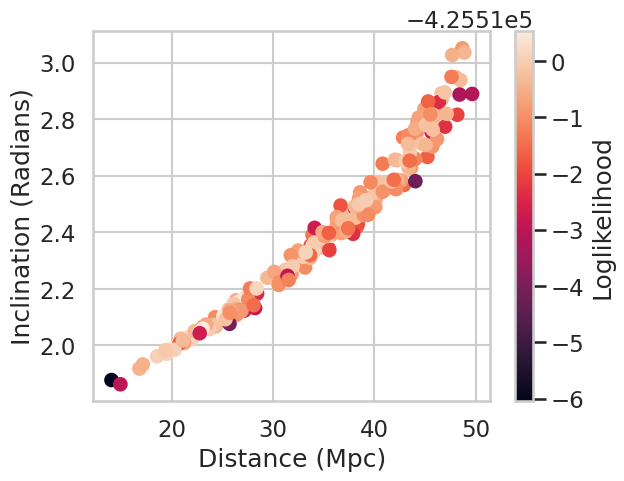

In [16]:
import pylab

lik = smpl.model_stats['loglikelihood']
s = smpl.samples

pylab.scatter(s['distance'][0,:,-1],
              s['inclination'][0,:,-1],
              c=lik[0,:,-1])
pylab.xlabel('Distance (Mpc)')
pylab.ylabel('Inclination (Radians)')
c = pylab.colorbar()
c.set_label('Loglikelihood')
pylab.show()

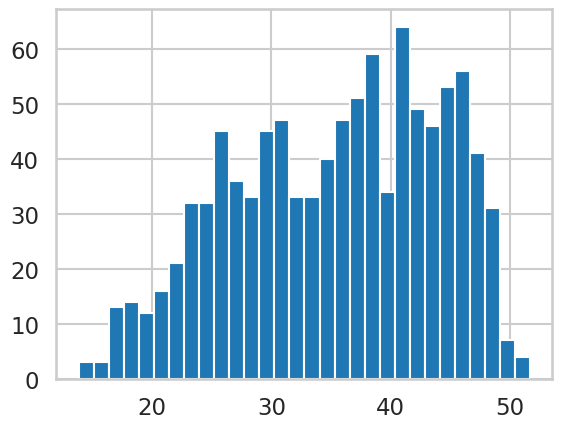

In [17]:
_ = pylab.hist(s['distance'][0,:,-100::20].flatten(), bins=30)

Saving the output

In [18]:
import pickle


# save dictionary to pdict1.pkl file
with open('par1.pkl', 'wb') as fp:
    pickle.dump(s, fp)
    print('Parameter values saved successfully to file')

with open('lik1.pkl', 'wb') as fp:
    pickle.dump(lik, fp)
    print('Likelihood values saved successfully to file')

Parameter values saved successfully to file
Likelihood values saved successfully to file


#### Watch how the position of the walkers evolves in time ###

We can see how our ensemble of walkers evolves with time using the animation utilities of matplotlib. We haven't covered the concept of "burn-in" in this tutorial, however, if you watch the animation, you can see the point
that the distribution is effectively burned-in.

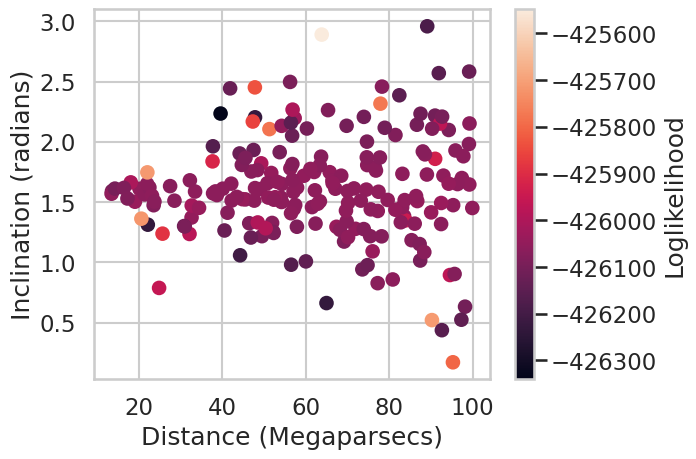

In [19]:
%matplotlib inline
from matplotlib import animation
import pylab

# We'll plot the initial position of the walkers
fig = pylab.figure(10)
a = pylab.scatter(s['distance'][0,:,0],
                  s['inclination'][0,:,0],
                  c=lik[0,:,0])
pylab.xlabel('Distance (Megaparsecs)')
pylab.ylabel('Inclination (radians)')
c = pylab.colorbar()
c.set_label('Loglikelihood')

# This function will update the plot with the ith iteration of our mcmc chain.
def animate(i):
    dat = numpy.array([s['distance'][0,:,i], s['inclination'][0,:,i]])
    a.set_offsets(dat.T)
    a.set_array(lik[0,:,i])
    return (a, )
    
nsamples = len(s['distance'][0,0,:])
ani = animation.FuncAnimation(fig, animate, frames=nsamples,
                              interval=200, blit=True)

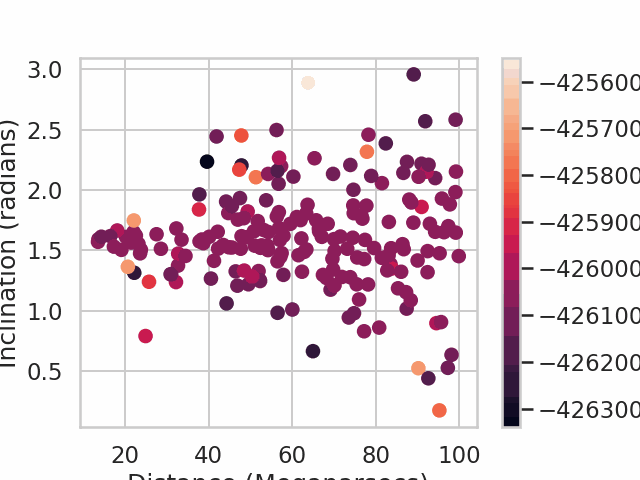

In [20]:
from matplotlib.animation import PillowWriter
from IPython.display import Image

ani.save('move.gif', writer=PillowWriter(fps=5))
with open('move.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

## Using the `pycbc_inference` command-line script

The examples above illustrated how the models and samplers are used in the inference module. While this is useful for quick checks, it's not feasible to do large-scale parameter estimation problems in a jupyter notebook. Instead, when actually doing parameter estimation, we use the command-line script `pycbc_inference`. This pulls together the sampler, models, and distributions modules so that we may perform Bayesian inference.

The key arguments that `pycbc_inference` takes are an output file and one or more `config-files` (run `pycbc_inference --help` to see all of the arguments it takes). The config files entirely specify the problem that you will be analyzing. In them, you specify the model to use, the variable parameters, and the prior on each of the parameters. If the model involves gravitational-wave data, you also specify what data to load and how to estimate the PSD. To see how this works, let's repeat the above analysis where we estimate the distance and inclination of GW170817 using the `SingleTempate` model.




###  Setting up the config file ###

*Note: in order to do everything from within the notebook, we'll create the config files by echoing a python string to  a file. In a normal situation, you would just use your favorite text editor to create the config files.* echo command in linux is used to display line of text/string that are passed as an argument. You can also use echo to to redirect the standard output of the command on the left and append it to the end of the file on the right. For excample:  echo "Hello world"  >> hello.txt. Whereas the command cat displays the contents of one or more files to the terminal. for example: cat hello.txt

In [21]:
# In config files section is given by [] and then there are options below it for that section

In [22]:
model_config = """
[model]
name = single_template
low-frequency-cutoff = 25.
"""
print(model_config)



[model]
name = single_template
low-frequency-cutoff = 25.



In [23]:
!echo '{model_config}' > model.ini 
!cat model.ini


[model]
name = single_template
low-frequency-cutoff = 25.



#### The data

Since this model uses data, we also need to create a data section that specifies what data to read for the analysis and the PSD estimation. See the [PyCBC Inference docs](https://pycbc.org/pycbc/latest/html/inference.html#setting-data) for more information about what options are available and what they mean.

In [24]:
data_config = """
[data]
instruments = H1 L1 V1
trigger-time = {event_tc}
analysis-start-time = -260
analysis-end-time = 40
strain-high-pass = 15
psd-estimation = median
psd-start-time = -260
psd-end-time = 40
psd-segment-length = 4
psd-segment-stride = 2
psd-inverse-length = 4
pad-data = 8
sample-rate = 2048
frame-files = H1:{h1file} L1:{l1file} V1:{v1file}
channel-name = H1:LOSC-STRAIN L1:LOSC-STRAIN V1:LOSC-STRAIN
""".format(event_tc=Merger("GW170817").time,
           h1file=data_filenames['H1'],
           l1file=data_filenames['L1'],
           v1file=data_filenames['V1'])

# data_filenames is dictionary defined before

In [25]:
!echo '{data_config}' > data.ini
!cat data.ini


[data]
instruments = H1 L1 V1
trigger-time = 1187008882.4
analysis-start-time = -260
analysis-end-time = 40
strain-high-pass = 15
psd-estimation = median
psd-start-time = -260
psd-end-time = 40
psd-segment-length = 4
psd-segment-stride = 2
psd-inverse-length = 4
pad-data = 8
sample-rate = 2048
frame-files = H1:/home/ash/.astropy/cache/download/url/c484b43c2c76aaf6fca1a057f4d6ed52/contents L1:/home/ash/.astropy/cache/download/url/9bb63179cc5cca254380aeb2ee25fd0d/contents V1:/home/ash/.astropy/cache/download/url/51cfa540d575027e191b029fedbda5db/contents
channel-name = H1:LOSC-STRAIN L1:LOSC-STRAIN V1:LOSC-STRAIN



#### The prior
Now let's specify the prior. We need to provide a section that lists the variable parameters and another that specifies the static parameters. For every variable parameter we have to provide one or more `prior` section(s) that specifies the prior distribution.

In [26]:
prior_config = """
[variable_params]
distance =
inclination =
delta_tc =
ra = 
dec =

[static_params]
mass1 = 1.3757
mass2 = 1.3757
f_lower = 25.0
approximant = TaylorF2
polarization = 0


[prior-distance]
name = uniform
min-distance = 10
max-distance = 100

[prior-inclination]
name = sin_angle

[prior-ra+dec]
; sky position prior
name = uniform_sky

[prior-delta_tc]
name = uniform
min-delta_tc = -0.1
max-delta_tc = 0.1

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc
"""

In [27]:
!echo '{prior_config}' > prior.ini
!cat prior.ini


[variable_params]
distance =
inclination =
delta_tc =
ra = 
dec =

[static_params]
mass1 = 1.3757
mass2 = 1.3757
f_lower = 25.0
approximant = TaylorF2
polarization = 0


[prior-distance]
name = uniform
min-distance = 10
max-distance = 100

[prior-inclination]
name = sin_angle

[prior-ra+dec]
; sky position prior
name = uniform_sky

[prior-delta_tc]
name = uniform
min-delta_tc = -0.1
max-delta_tc = 0.1

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc



*But wait!* There's something odd here: the list of variable parameters contains a `delta_tc`, whereas we need to provide a `tc` for the coalescence time. Emcee understand tc and not delta_tc. This illustrates that the `variable_params` can be anything we like them to be with any name (we could have called `delta_tc` `foobar` if we liked). They do not need to be predefined in code anywhere. However, the waveform models do need specific parameters to be provided in order to generate a template waveform. If we use a parameter that is not recognized by the waveform model (see [here](https://pycbc.org/pycbc/latest/html/inference.html#waveform-transforms) for a list of known parameters), then we must provide a `waveform_transforms` section that tells the code how to convert that parameter into something that the waveform model recognizes. In this case, `delta_tc` is not recognized by the waveform model, but `tc` is. So, we've provided a section that converts `delta_tc` into `tc` by adding the trigger time. Also note that when providing the trigger time we used `${data|trigger-time}`. We can use variable substitution in config files. In this case, we've told the config file to get the trigger time that's stored in the `[data]` section. This illustrates why we've chosen to make `delta_tc` the variable parameter: we do not need to copy and paste hard-to-read GPS times all over the place. Instead, we only need provide a time in one location, then refer to it elsewhere. This makes it clear and easy to specify the tc prior, which is just a uniform window +/- 0.1s around the estimated time. Another advantage of this is we could analyze other events using the same prior file, just swapping out data files.

We will see some other, more advanced uses of waveform transforms below.

#### The sampler

Finally, we need to specify the sampler settings. To do that, we need to provide a `sampler` section.

In [28]:
sampler_config = """
[sampler]
name = emcee_pt
ntemps = 3
nwalkers = 200
niterations = 400
max-samples-per-chain = 1000

[sampler-burn_in]
burn-in-test = halfchain
"""

In [29]:
!echo '{sampler_config}' > sampler.ini
!cat sampler.ini


[sampler]
name = emcee_pt
ntemps = 3
nwalkers = 200
niterations = 400
max-samples-per-chain = 1000

[sampler-burn_in]
burn-in-test = halfchain



Note that we've also provided a burn-in test. Here, we're telling it just use the second half of the chain. This means that at the end of the run, it will consider the second half of the chains to be post-burn in. An autocorrelation time will be computed over this and a posterior extracted. More sophisticated burn-in tests are available; see the [pycbc.inference.burn_in module](https://pycbc.org/pycbc/latest/html/pycbc.inference.html#module-pycbc.inference.burn_in) for more details.

### Run `pycbc_inference`

Now that we've set up our config files, we can run `pycbc_inference`:

In [30]:
!pycbc_inference --verbose \
    --seed 1998 \
    --config-files data.ini model.ini prior.ini sampler.ini \
    --output-file inference.hdf \
    --nprocesses 4 \
    --force     
    # overwrite if file already exists # seed is the random seed (but why do we need it?)
    # --verbose tells us the messages of what it is doing in the program

2023-07-19T20:49:10.415+05:30 Using seed 1998
2023-07-19T20:49:10.416+05:30 Running with CPU support: 1 threads
2023-07-19T20:49:10.607+05:30 Reading configuration file
2023-07-19T20:49:10.613+05:30 Setting up model
2023-07-19T20:49:10.615+05:30 Setting up priors for each parameter
2023-07-19T20:49:10.617+05:30 No sampling_params section read from config file
2023-07-19T20:49:10.617+05:30 Loading waveform transforms
2023-07-19T20:49:10.623+05:30 Determining analysis times to use
2023-07-19T20:49:10.623+05:30 Padding H1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2023-07-19T20:49:10.623+05:30 Padding L1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2023-07-19T20:49:10.623+05:30 Padding V1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2023-07-19T20:49:10.624+05:30 Reading Frames
2023-07-19T20:49:22.767+05:

Now that it's done, we can see that an `inference.hdf` file exists in our directory:

In [31]:
!ls -lh inference.hdf

-rw-rw-r-- 1 ash ash 250M Jul 19 20:52 inference.hdf


This contains all of the samples, and the information needed to extract the posterior from it, along with other diagnostic information about the sampler. Below, we show how to plot a posterior from this.

In [32]:
import h5py

# Open the HDF file
f = h5py.File("inference.hdf", "r")
print("Keys are:", f.keys())
print("Samples available are:", f['samples'].keys())
print("Posteriors look like: ", f['samples']['distance'])

Keys are: <KeysViewHDF5 ['config_file', 'data', 'sampler_info', 'samples']>
Samples available are: <KeysViewHDF5 ['dec', 'delta_tc', 'distance', 'inclination', 'logjacobian', 'loglikelihood', 'logprior', 'ra']>
Posteriors look like:  <HDF5 dataset "distance": shape (3, 200, 400), type "<f8">


### Get the extrinsic parameters

For speed, we'll fix the extrinsic parameters. We'll use our previous results using the `SingleTemplate` model to get the maximum likelihood values of the distance, inclination, and coalescence time. To do that, we'll use `pycbc_inference_table_summary` to print out a table of the values.

In [33]:
!pycbc_inference_table_summary \
    --input-file inference.hdf \
    --output-file posterior_summary.html \
    --verbose

2023-07-19T20:53:06.292+05:30 Reading input file inference.hdf
2023-07-19T20:53:06.295+05:30 Loading samples
2023-07-19T20:53:06.330+05:30 Loaded 1400 samples


In [34]:
from IPython.display import HTML
HTML('posterior_summary.html')

'ra': 3.44615914,
'dec': -0.40808407

##  Plotting the posterior using `pycbc_inference_plot_posterior`

The command-line tool `pycbc_inference_plot_posterior` is used to make corner and posterior plots of our results. We can give it either the direct output of `pycbc_inference` (here, `inference.hdf`) or a posterior file created using `pycbc_inference_extract_samples`. There are several plotting configuration options available (see `pycbc_inference_plot_posterior --help` for the list of options). Here we'll illustrate a few.

### Corner scatter plot
Let's create a corner plot of our results. We'll show every sample in our posterior colored by the signal-to-noise ratio (here defined as $\sqrt{2\mathcal{L}}$ where $\mathcal{L}$ is the log likelihood ratio).

In [35]:
!pycbc_inference_plot_posterior --verbose --input-file inference.hdf \
    --output-file posterior.png \
    --plot-scatter --plot-marginal --z-arg snr
    # --verbose tells us the messages of what it is doing in the program
    # marginal is the 1D marginal plots
    # SNR is the cmap of matplotlib

2023-07-19T20:53:14.322+05:30 Reading input file inference.hdf
2023-07-19T20:53:14.324+05:30 Loading samples
2023-07-19T20:53:14.341+05:30 Loaded 1400 samples
2023-07-19T20:53:14.341+05:30 Getting samples for colorbar
2023-07-19T20:53:14.351+05:30 Plotting
2023-07-19T20:53:19.463+05:30 Done


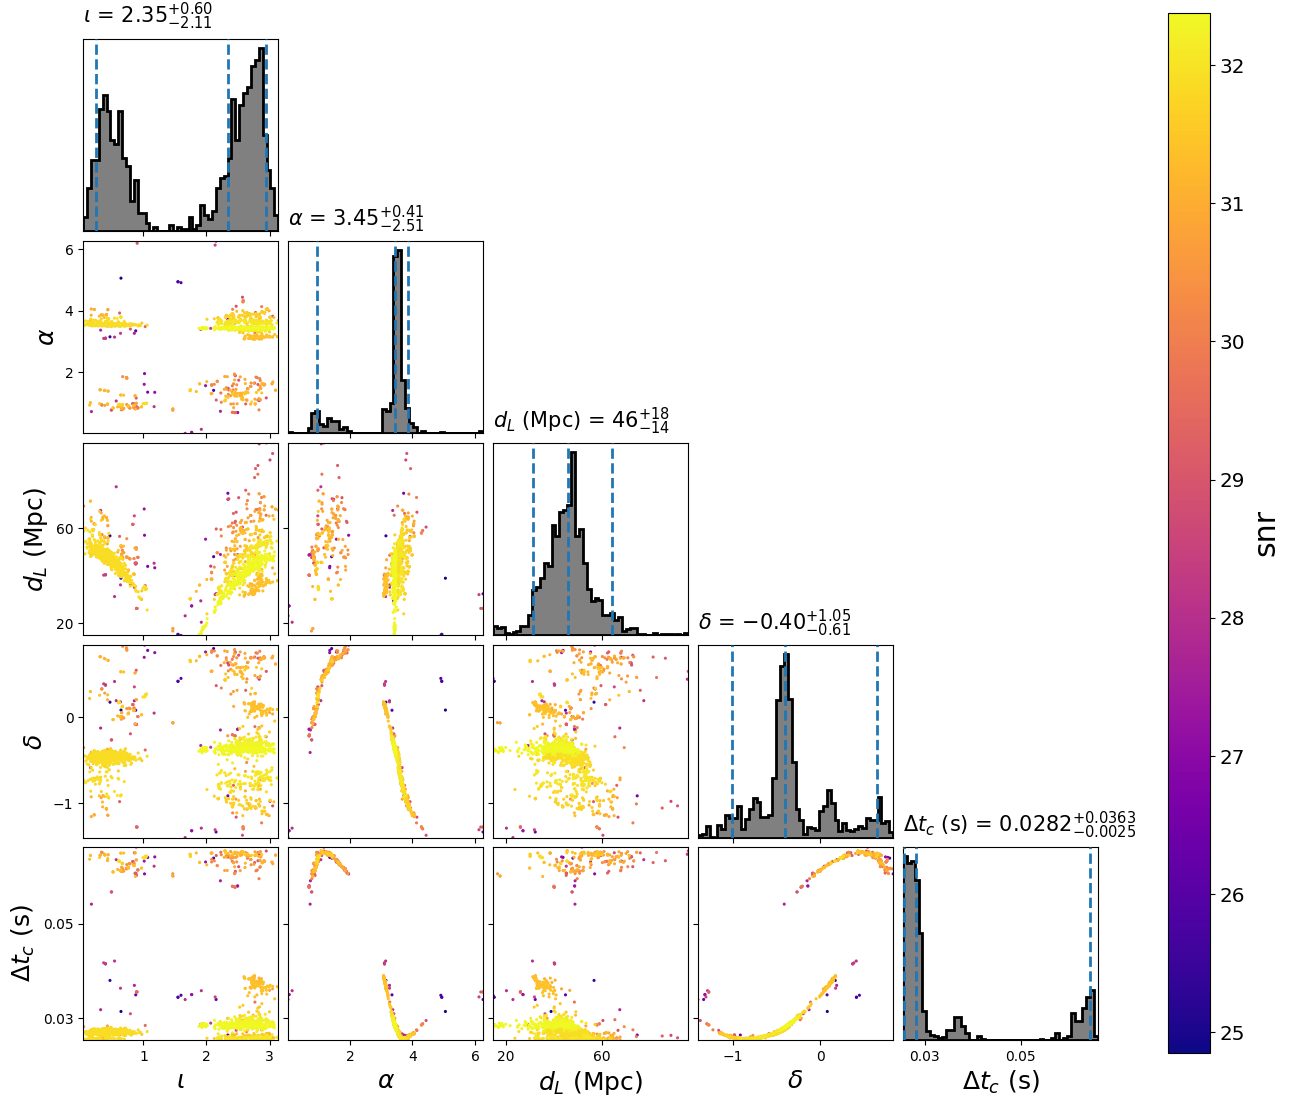

In [36]:
Image('posterior.png', height=480)

### 2D density plot

By default, we see that it has plotted all of the `variable_params`. Let's just plot distance vs inclination instead. We can do that via the `--parameters` argument. Let's also make a density plot with 2D marginal contours rather than a scatter plot. We'll do that by dropping the `--plot-scatter` and `--z-arg` commands, adding `--plot-density` and `--plot-contours` instead.

In [37]:
!pycbc_inference_plot_posterior --verbose \
    --input-file inference.hdf \
    --output-file posterior-dist_inc.png \
    --plot-density --plot-contours --plot-marginal \
    --parameters inclination distance
    # density plots are plotted
    # contours are also plotted over the density plots
    # 1D marginals are also plotted
    # just for parameters distance vs inclination

2023-07-19T20:53:26.930+05:30 Reading input file inference.hdf
2023-07-19T20:53:26.932+05:30 Loading samples
2023-07-19T20:53:26.944+05:30 Loaded 1400 samples
2023-07-19T20:53:26.944+05:30 Plotting
2023-07-19T20:53:29.807+05:30 Done


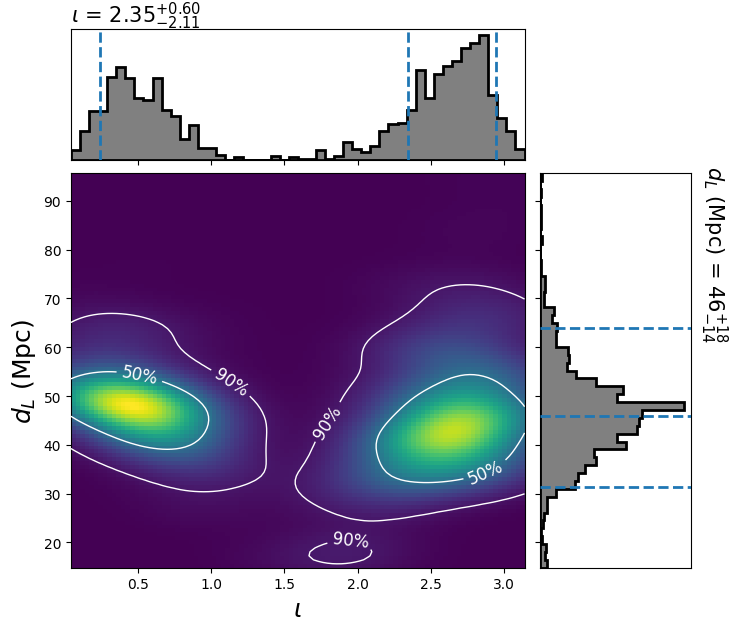

In [38]:
Image('posterior-dist_inc.png', height=480)

### Manipulating parameters on the command line

The `--parameters` can be used to do more than just turn certain parameters on or off. We can also apply math functions to parameters using standard python syntax. Any numpy function may be used. Functions from the  [pycbc.conversions](http://pycbc.org/pycbc/latest/html/pycbc.html#module-pycbc.conversions), [pycbc.coordinates](http://pycbc.org/pycbc/latest/html/pycbc.html#module-pycbc.coordinates), or [pycbc.cosmology](http://pycbc.org/pycbc/latest/html/pycbc.html#module-pycbc.cosmology) modules are also available. To see all of the parameters in our results file, along with all the functions that may be carried out on them, we can use the `--file-help` argument. This will print a message to screen then exit:

In [39]:
!pycbc_inference_plot_posterior --input-file inference.hdf --file-help


Parameters available with this (these) input file(s):

dec delta_tc distance inclination logjacobian loglikelihood logprior
ra

Available pycbc functions (see http://pycbc.org/pycbc/latest/html for
more details):

average_time_between_signals, cartesian_to_spherical,
cartesian_to_spherical_azimuthal, cartesian_to_spherical_polar,
cartesian_to_spherical_rho, chi_a, chi_eff, chi_eff_from_spherical,
chi_p, chi_p_from_spherical, chi_p_from_xi1_xi2,
chi_perp_from_mass1_mass2_xi2, chi_perp_from_spinx_spiny,
chirp_distance, coalescence_rate, cosmological_quantity_from_redshift,
det_tc, diff_lookback_time, distance_from_comoving_volume,
distance_from_rate, dquadmon_from_lambda, eta_from_mass1_mass2,
eta_from_q, eta_from_tau0_tau3, final_mass_from_f0_tau,
final_mass_from_initial, final_spin_from_f0_tau,
final_spin_from_initial, freq_from_final_mass_spin,
freqlmn_from_other_lmn, invq_from_mass1_mass2,
lambda_from_mass_tov_file, lambda_tilde, mass1_from_mass2_eta,
mass1_from_mchirp_eta, mass1_fr

One of the available functions, [redshift](https://pycbc.org/pycbc/latest/html/pycbc.html#pycbc.cosmology.redshift), takes in luminosity distance and converts it to redshift assuming a standard cosmology. Let's use that, and some of the numpy functions, to plot redshift versus inclination angle in degrees. Let's also add a line at the redshift of [NGC4993](https://en.wikipedia.org/wiki/NGC_4993) to see how well our results agree. We'll do that using the `--expected-parameters` command.

In [40]:
!pycbc_inference_plot_posterior --verbose \
    --input-file inference.hdf \
    --output-file posterior-redshift_inc.png \
    --plot-density --plot-contours --plot-marginal \
    --parameters 'inclination*180/pi:$\iota$ (deg)' 'redshift(distance):redshift' \
    --expected-parameters 'redshift(distance):0.009727'
    # expected parameters draw a line on the plot

2023-07-19T20:53:44.712+05:30 Reading input file inference.hdf
2023-07-19T20:53:44.714+05:30 Loading samples
2023-07-19T20:53:44.727+05:30 Loaded 1400 samples
2023-07-19T20:53:46.354+05:30 Plotting
2023-07-19T20:53:48.984+05:30 Done


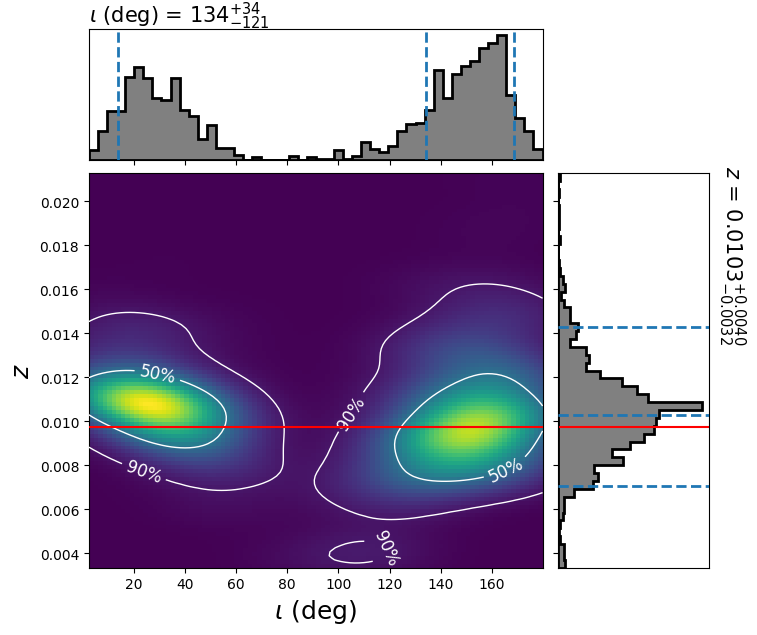

In [41]:
Image('posterior-redshift_inc.png', height=480)

## Estimate the masses of GW170817 ##

In the previous example we quickly estimated the extrinsic parameters of GW170817 by fixing the intrinsic. This was fast, since it did not require regenerating a waveform for each likelihood evaluation. Now let's try estimating the masses of GW170817. This is generally slower, since it requires generating a waveform on each likelihood call. However, in the example below, we'll use the [relative binning model](https://pycbc.org/pycbc/latest/html/pycbc.inference.models.html#pycbc.inference.models.relbin.Relative). This uses a technique presented in [Zackay et al.](https://arxiv.org/abs/1806.08792). Basically, a reference waveform is used that's close to the peak likelihood. A linear approximation is used to interpolate the likelihood around this waveform, reducing the number of frequency points that we need to evaluate, and speeding up the analysis.

To do this, we'll use the same `data.ini` and `sampler.ini` files as above. We'll change the `model` to the `relative` one and provide the necessary arguments to generate the fiducial waveform. We'll make the chirp mass (`mchirp`) and symmetric mass ratio (`eta`) the variable parameters; for speed, we'll fix the extrinsic parameters.

### Setup the config files

In [42]:
model_config = """
[model]
name = relative
low-frequency-cutoff = 25.0
high-frequency-cutoff = 1024.0
epsilon = 0.03
mass1_ref = 1.3757
mass2_ref = 1.3757
tc_ref = ${data|trigger-time}
"""

In [43]:
!echo '{model_config}' > model.ini
!cat model.ini


[model]
name = relative
low-frequency-cutoff = 25.0
high-frequency-cutoff = 1024.0
epsilon = 0.03
mass1_ref = 1.3757
mass2_ref = 1.3757
tc_ref = ${data|trigger-time}



In [44]:
prior_config = """
[variable_params]
mass1 =
mass2 =

[static_params]
f_lower = 25.0
approximant = TaylorF2
polarization = 0
ra = 3.44615914
dec = -0.40808407
distance = 48
inclination = 3
delta_tc = 0.028365

[prior-mass1]
name = uniform
min-mass1 = 1
max-mass1 = 2

[prior-mass2]
name = uniform
min-mass2 = 1
max-mass2 = 2

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc

"""

In [45]:
!echo '{prior_config}' > prior.ini
!cat prior.ini


[variable_params]
mass1 =
mass2 =

[static_params]
f_lower = 25.0
approximant = TaylorF2
polarization = 0
ra = 3.44615914
dec = -0.40808407
distance = 48
inclination = 3
delta_tc = 0.028365

[prior-mass1]
name = uniform
min-mass1 = 1
max-mass1 = 2

[prior-mass2]
name = uniform
min-mass2 = 1
max-mass2 = 2

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc




### Run

*Note: this may take several minutes to run.*

In [46]:
!pycbc_inference --verbose \
    --config-files model.ini data.ini prior.ini sampler.ini \
    --output-file inference-masses.hdf \
    --seed 3214897 \
    --nprocesses 8 \
    --force    

2023-07-19T20:54:03.631+05:30 Using seed 3214897
2023-07-19T20:54:03.631+05:30 Running with CPU support: 1 threads
2023-07-19T20:54:03.792+05:30 Reading configuration file
2023-07-19T20:54:03.826+05:30 Setting up model
2023-07-19T20:54:03.830+05:30 Setting up priors for each parameter
2023-07-19T20:54:03.831+05:30 No sampling_params section read from config file
2023-07-19T20:54:03.831+05:30 Loading waveform transforms
2023-07-19T20:54:03.839+05:30 Determining analysis times to use
2023-07-19T20:54:03.839+05:30 Padding H1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2023-07-19T20:54:03.839+05:30 Padding L1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2023-07-19T20:54:03.839+05:30 Padding V1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2023-07-19T20:54:03.841+05:30 Reading Frames
2023-07-19T20:54:17.863+

### Plot the posterior

In [47]:
!pycbc_inference_plot_posterior --verbose \
    --input-file inference-masses.hdf \
    --output-file posterior.png \
    --plot-scatter --plot-marginal --z-arg snr\
    --expected-parameters 'mass1:1.3757' 'mass2:1.3757'


2023-07-19T20:59:58.315+05:30 Reading input file inference-masses.hdf
2023-07-19T20:59:58.317+05:30 Loading samples
2023-07-19T20:59:58.331+05:30 Loaded 1400 samples
2023-07-19T20:59:58.331+05:30 Getting samples for colorbar
2023-07-19T20:59:58.341+05:30 Plotting
2023-07-19T21:00:00.584+05:30 Done


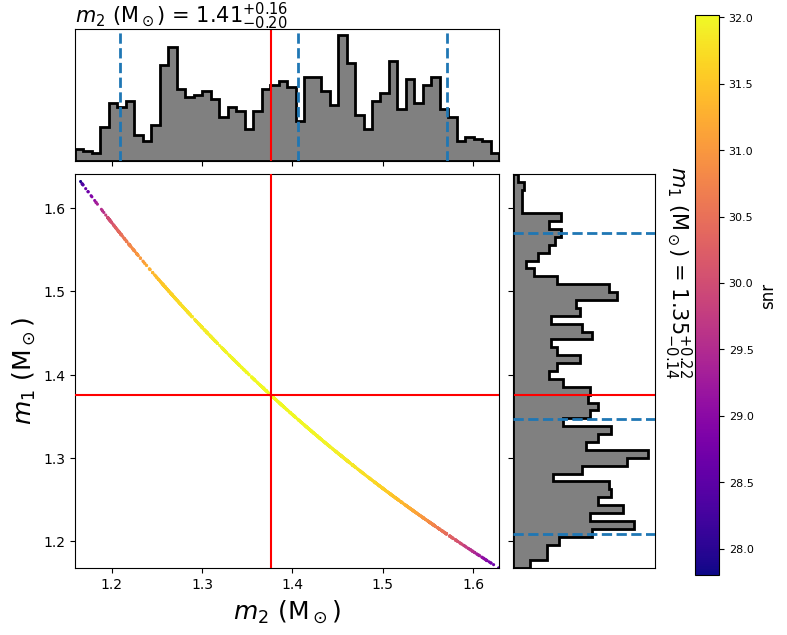

In [48]:
Image('posterior.png', height=480)

# Chirp Mass vs Symmetric Mass

In [49]:
prior_config = """
[variable_params]
mchirp =
eta =

[static_params]
f_lower = 25.0
approximant = TaylorF2
polarization = 0
ra = 3.44615914
dec = -0.40808407
distance = 48
inclination = 3.0
delta_tc = 0.028365

[prior-mchirp]
name = uniform
min-mchirp = 1.1876
max-mchirp = 1.2076

[prior-eta]
name = uniform
min-eta = 0.23
max-eta = 0.25

[waveform_transforms-mass1+mass2]
; transform from mchirp, eta to mass1, mass2 for waveform generation
name = mchirp_eta_to_mass1_mass2

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc
"""

In [50]:
!echo '{prior_config}' > prior.ini
!cat prior.ini


[variable_params]
mchirp =
eta =

[static_params]
f_lower = 25.0
approximant = TaylorF2
polarization = 0
ra = 3.44615914
dec = -0.40808407
distance = 48
inclination = 3.0
delta_tc = 0.028365

[prior-mchirp]
name = uniform
min-mchirp = 1.1876
max-mchirp = 1.2076

[prior-eta]
name = uniform
min-eta = 0.23
max-eta = 0.25

[waveform_transforms-mass1+mass2]
; transform from mchirp, eta to mass1, mass2 for waveform generation
name = mchirp_eta_to_mass1_mass2

[waveform_transforms-tc]
name = custom
inputs = delta_tc
tc = ${data|trigger-time} + delta_tc



In [51]:
!pycbc_inference --verbose \
    --config-files model.ini data.ini prior.ini sampler.ini \
    --output-file inference-chirpmass.hdf \
    --seed 3214897 \
    --nprocesses 8 \
    --force    

2023-07-19T21:00:11.505+05:30 Using seed 3214897
2023-07-19T21:00:11.505+05:30 Running with CPU support: 1 threads
2023-07-19T21:00:11.659+05:30 Reading configuration file
2023-07-19T21:00:11.664+05:30 Setting up model
2023-07-19T21:00:11.670+05:30 Setting up priors for each parameter
2023-07-19T21:00:11.671+05:30 No sampling_params section read from config file
2023-07-19T21:00:11.672+05:30 Loading waveform transforms
2023-07-19T21:00:11.680+05:30 Determining analysis times to use
2023-07-19T21:00:11.680+05:30 Padding H1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2023-07-19T21:00:11.680+05:30 Padding L1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2023-07-19T21:00:11.680+05:30 Padding V1 analysis start and end times by 2 (= psd-inverse-length/2) seconds to account for PSD wrap around effects.
2023-07-19T21:00:11.683+05:30 Reading Frames
2023-07-19T21:00:24.337+

In [52]:
!pycbc_inference_plot_posterior --verbose \
    --input-file inference-chirpmass.hdf \
    --output-file posterior.png \
    --plot-scatter --plot-marginal --z-arg snr \
    --parameters mchirp eta

2023-07-19T21:04:56.681+05:30 Reading input file inference-chirpmass.hdf
2023-07-19T21:04:56.683+05:30 Loading samples
2023-07-19T21:04:56.696+05:30 Loaded 1600 samples
2023-07-19T21:04:56.697+05:30 Getting samples for colorbar
2023-07-19T21:04:56.706+05:30 Plotting
2023-07-19T21:04:57.428+05:30 Substituting symbol M from STIXNonUnicode
2023-07-19T21:04:57.537+05:30 Substituting symbol M from STIXNonUnicode
2023-07-19T21:04:58.054+05:30 Substituting symbol M from STIXNonUnicode
2023-07-19T21:04:58.125+05:30 Substituting symbol M from STIXNonUnicode
2023-07-19T21:04:58.455+05:30 Done


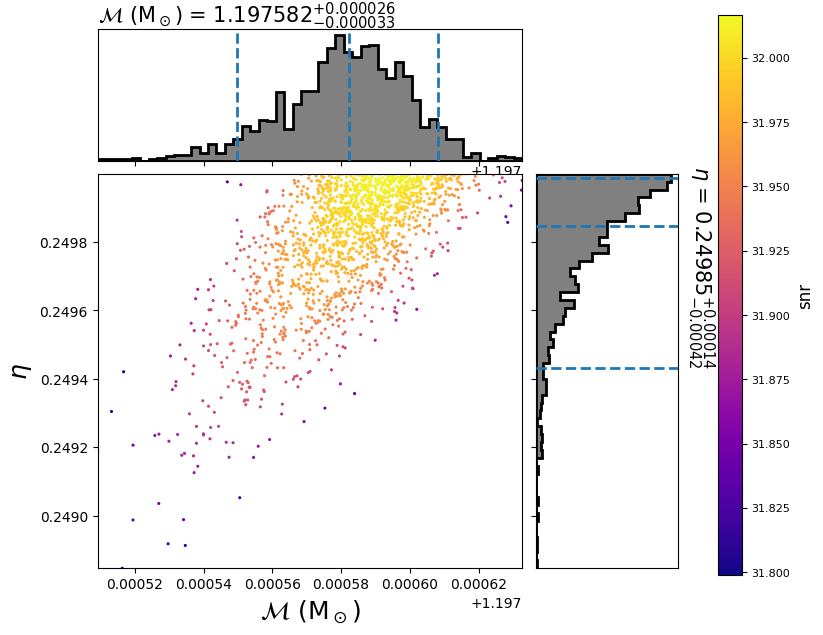

In [53]:
Image('posterior.png', height=480)